# Setting Up the Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

sns.set_theme()

In [2]:
# BUSINESS DATA

# Read json file
business = pd.read_json('yelp_academic_dataset_business.json', lines=True)
# Remove superfluous data
business = business.drop(columns=['name', 'address', 'city', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'hours'])

# Only keep businesses in the 'Restaurants' category
business = business[business['categories'].str.contains('Restaurants', na = False)]
# Remove restaurants that are not in the US
business = business[(business['state'] != "ABE") & (business['state'] != "BC")]

business.head()

business_id state  is_open  \
0   6iYb2HFDywm3zjuRg0shjw    CO        1   
1   tCbdrRPZA0oiIYSmHG3J0w    OR        1   
7   jFYIsSb7r1QeESVUnXPHBw    OH        1   
12  HPA_qyMEddpAEtFof02ixg    MA        1   
13  ufCxltuh56FF4-ZFZ6cVhg    FL        1   

                                           attributes  \
0   {'RestaurantsTableService': 'True', 'WiFi': 'u...   
1   {'RestaurantsTakeOut': 'True', 'RestaurantsAtt...   
7                                                None   
12  {'RestaurantsGoodForGroups': 'True', 'HasTV': ...   
13  {'BusinessParking': '{'garage': False, 'street...   

                                           categories  
0   Gastropubs, Food, Beer Gardens, Restaurants, B...  
1   Salad, Soup, Sandwiches, Delis, Restaurants, C...  
7                     Breakfast & Brunch, Restaurants  
12                           Food, Pizza, Restaurants  
13  Restaurants, American (New), Bakeries, Dessert...

In [3]:
# REVIEW DATA

# Read json file in chunks to prevent a memory error
review_json_path = 'yelp_academic_dataset_review.json'
size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

# Strip unnecessary data from each data chunk and add to list
chunk_list = []
for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','user_id','stars','text','useful','funny','cool'], axis=1)
    chunk_list.append(chunk_review)
    
# Concatenate data
review = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

review.head()

business_id                 date
0  buF9druCkbuXLX526sGELQ  2014-10-11 03:34:02
1  RA4V8pr014UyUbDvI-LW2A  2015-07-03 20:38:25
2  _sS2LBIGNT5NQb6PD1Vtjw  2013-05-28 20:38:06
3  0AzLzHfOJgL7ROwhdww2ew  2010-01-08 02:29:15
4  8zehGz9jnxPqXtOc7KaJxA  2011-07-28 18:05:01

# Restaurants Data for 2020 and 2021

In [19]:
# CLEANED AND MERGED DATA OF RESTAURANTS IN 2020 AND 2021

# Only keep reviews that are from 2020 and 2021
review_ur = review[review['date'].str.contains('2020') | review['date'].str.contains('2021')].copy()
# Change review date type from string to date time
review_ur['date'] = review_ur['date'].astype("datetime64")
# Add year and month columns
review_ur['month-year'] = pd.to_datetime(review_ur['date']).dt.to_period('M')

# Merge the business and review datasets using business ID to identify all restaurants have reviews in 2020 and 2021
bus_rev = pd.merge(business, review_ur, on='business_id')
bus_rev = bus_rev.sort_values(by=['date'])
# Remove duplicates of restaurants and make each row's date the last review date for each unique business ID
bus_unique = bus_rev.groupby('business_id').last()

bus_unique.head()

state  is_open  \
business_id                             
--Q3mAcX9t63f7Xcbn7LVA    OH        1   
--UNNdnHRhsyFUbDgumdtQ    OR        1   
-00d-Qb0q2TcWn-8LBHDZg    MA        1   
-0JXXCMUpe29dQ-f6pG9OA    GA        1   
-0OWS89ebRdvzOQkjptyEw    GA        1   

                                                               attributes  \
business_id                                                                 
--Q3mAcX9t63f7Xcbn7LVA  {'Ambience': '{'touristy': False, 'hipster': F...   
--UNNdnHRhsyFUbDgumdtQ  {'RestaurantsPriceRange2': '3', 'BusinessParki...   
-00d-Qb0q2TcWn-8LBHDZg  {'RestaurantsAttire': 'u'casual'', 'Alcohol': ...   
-0JXXCMUpe29dQ-f6pG9OA  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   
-0OWS89ebRdvzOQkjptyEw  {'BikeParking': 'False', 'DriveThru': 'False',...   

                                                               categories  \
business_id                                                                 
--Q3mAcX9t63f7Xcbn7LVA    American (Traditional), Restaurants, Gastropubs   
--UNNdnHRhsyFUbDgumdtQ                French, Restaurants, American (New)   
-00d-Qb0q2TcWn-8LBHDZg  Food Trucks, Food, Street Vendors, Food Stands...   
-0JXXCMUpe29dQ-f6pG9OA  Food, Restaurants, Juice Bars & Smoothies, Hea...   
-0OWS89ebRdvzOQkjptyEw                               Restaurants, Burgers   

                                      date month-year  
business_id                                            
--Q3mAcX9t63f7Xcbn7LVA 2021-01-27 02:15:07    2021-01  
--UNNdnHRhsyFUbDgumdtQ 2020-12-17 17:35:28    2020-12  
-00d-Qb0q2TcWn-8LBHDZg 2021-01-22 14:07:27    2021-01  
-0JXXCMUpe29dQ-f6pG9OA 2020-06-02 23:24:14    2020-06  
-0OWS89ebRdvzOQkjptyEw 2020-11-22 15:33:49    2020-11

In [20]:
# Total number of restaurants that were open in 2020/2021 are still open or no longer open

is_open = bus_unique.groupby('is_open').count()
is_open

state  attributes  categories   date  month-year
is_open                                                  
0         1838        1831        1838   1838        1838
1        24758       24556       24758  24758       24758

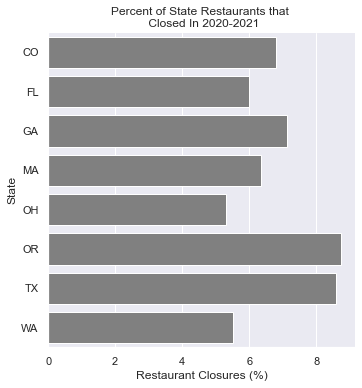

In [21]:
# Percent of restaurant closures per state in 2020/2021

# Divide num of closed restaurants in each s by total restaurants in each state
group_state = bus_unique.groupby('state').count()
closed_state = bus_unique[bus_unique['is_open'] == 0].groupby('state').count()
closed = (closed_state / group_state) * 100

# Merge dataset to make data workable, then visualize data
closed.reset_index(inplace=True)
pc_plt = sns.catplot(data= closed.dropna(), x="is_open", y="state", height= 5, color = "gray", kind="bar")
pc_plt.set(xlabel='Restaurant Closures (%)', ylabel='State', title='Percent of State Restaurants that \n Closed In 2020-2021')

In [22]:
# Percent of closures per month of last review

group_date = len(bus_unique[bus_unique['is_open'] == 0])
closed_date = bus_unique[bus_unique['is_open'] == 0].groupby('month-year').count()
closed = (closed_date / group_date) * 100

closed.reset_index(inplace=True)
c = sns.catplot(data= closed, x="is_open", y="month-year", height= 5, color = "gray", kind="bar")
c.set(xlabel='Restaurant Closures (%)', ylabel='Last Review Date (Year-Month)', title='Distribution of 2020-2021 Restaurant Closures \n per Month of Last Yelp Review')

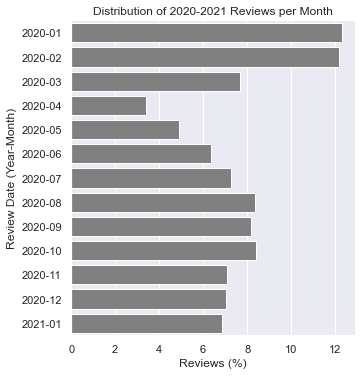

In [28]:
# Percent of reviews per month
tot_revs = len(bus_rev)
group_num = bus_rev.groupby('month-year').count()
group_num = (group_num / tot_revs) * 100
group_num.reset_index(inplace=True)

n = sns.catplot(data= group_num, x="date", y="month-year", height= 5, color = "gray", kind="bar")
n.set(xlabel='Reviews (%)', ylabel='Review Date (Year-Month)', title='Distribution of 2020-2021 Reviews per Month')

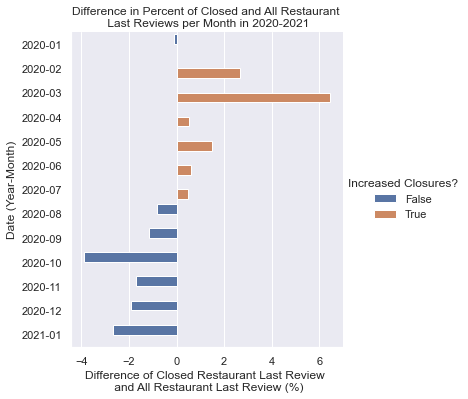

In [26]:
# Percent diff between the closed last review distribution and total review distribution
group_num['dif'] = closed['date'] - group_num['date']
group_num['Increased Closures?'] = group_num['dif'] > 0

n = sns.catplot(data= group_num, x="dif", y="month-year", height= 5, hue ="Increased Closures?", kind="bar")
n.set(xlabel='Difference of Closed Restaurant Last Review \n and All Restaurant Last Review (%)', ylabel='Date (Year-Month)', title='Difference in Percent of Closed and All Restaurant \n Last Reviews per Month in 2020-2021')

# Restaurant Data for 2019

In [10]:
# MERGED DATA OF RESTAURANTS IN 2019

# Only keep reviews that are from 2019, 2020, or 2021
review_ur = review[review['date'].str.contains('2019') | review['date'].str.contains('2020') | review['date'].str.contains('2021')].copy()
# Change review date type from string to date time
review_ur['date'] = review_ur['date'].astype("datetime64")
# Add year and month columns
review_ur['month-year'] = pd.to_datetime(review_ur['date']).dt.to_period('M')
# Merge the business and review datasets using business ID to identify all restaurants have reviews in 2019, 2020, or 2021
bus_rev = pd.merge(business, review_ur, on='business_id')
bus_rev = bus_rev.sort_values(by=['date'])
# Remove duplicates of restaurants and make each row's date the last review date for each unique business ID
bus_unique = bus_rev.groupby('business_id').last()

bus_unique.head()

state  is_open  \
business_id                             
--Q3mAcX9t63f7Xcbn7LVA    OH        1   
--UNNdnHRhsyFUbDgumdtQ    OR        1   
-00d-Qb0q2TcWn-8LBHDZg    MA        1   
-0A60UZl9nbdq2WWySJ_tQ    FL        0   
-0JXXCMUpe29dQ-f6pG9OA    GA        1   

                                                               attributes  \
business_id                                                                 
--Q3mAcX9t63f7Xcbn7LVA  {'Ambience': '{'touristy': False, 'hipster': F...   
--UNNdnHRhsyFUbDgumdtQ  {'RestaurantsPriceRange2': '3', 'BusinessParki...   
-00d-Qb0q2TcWn-8LBHDZg  {'RestaurantsAttire': 'u'casual'', 'Alcohol': ...   
-0A60UZl9nbdq2WWySJ_tQ  {'Ambience': '{'romantic': False, 'intimate': ...   
-0JXXCMUpe29dQ-f6pG9OA  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   

                                                               categories  \
business_id                                                                 
--Q3mAcX9t63f7Xcbn7LVA    American (Traditional), Restaurants, Gastropubs   
--UNNdnHRhsyFUbDgumdtQ                French, Restaurants, American (New)   
-00d-Qb0q2TcWn-8LBHDZg  Food Trucks, Food, Street Vendors, Food Stands...   
-0A60UZl9nbdq2WWySJ_tQ            Restaurants, Breakfast & Brunch, Diners   
-0JXXCMUpe29dQ-f6pG9OA  Food, Restaurants, Juice Bars & Smoothies, Hea...   

                                      date month-year  
business_id                                            
--Q3mAcX9t63f7Xcbn7LVA 2021-01-27 02:15:07    2021-01  
--UNNdnHRhsyFUbDgumdtQ 2020-12-17 17:35:28    2020-12  
-00d-Qb0q2TcWn-8LBHDZg 2021-01-22 14:07:27    2021-01  
-0A60UZl9nbdq2WWySJ_tQ 2019-10-23 21:56:53    2019-10  
-0JXXCMUpe29dQ-f6pG9OA 2020-06-02 23:24:14    2020-06

In [11]:
# CLEANED DATA OF RESTAURANTS IN 2019

# Get restaurants whos last review was in 2019 and are now closed, presumed closed in 2019
closed_2019 = bus_unique[(bus_unique['date'] < pd.to_datetime('2020-01-01 00:00:00')) & (bus_unique['is_open'] == 0)]

# Get reviews for businesses that had reviews in 2019 and 2020/2021
open_2019 = review_ur.groupby('business_id').agg([np.min, np.max])['month-year']
open_2019 = open_2019[(open_2019['amin'] < pd.Period('2020-01')) & (open_2019['amax'] >= pd.Period('2020-01'))]
open_2019.reset_index(inplace=True)
open_2019 = pd.merge(review_ur, open_2019, how="inner")
open_2019 = open_2019.drop(['amin','amax'], axis=1)

# Merge reviews of businesses that had reviews in 2019 and 2020/2021 with restaurant business data
open_2019 = pd.merge(open_2019, business, on='business_id')
# Change is_open to 1 because restaurant must have been open thru all of 2019 given it had reviews in 2020/2021
open_2019 = open_2019.replace(0, 1)
# Only keep 2019 reviews
open_revs = open_2019[open_2019['month-year'] < pd.Period('2020-01')]
open_revs = open_revs.sort_values(by=['date'])
# Remove duplicates of restaurants and make each row's date the last review date for each unique business ID
open_2019_u = open_revs.groupby('business_id').last()

# Get reviews for businesses that had reviews in 2019 only
closed = review_ur.groupby('business_id').max()
closed = closed[closed['month-year'] < pd.Period('2020-01')]
closed.reset_index(inplace=True)
closed = pd.merge(review_ur, closed, how="inner")

# Merge reviews of businesses that had reviews in 2019 with restaurant business data to get reviews for closed restaurants
closed = pd.merge(business, closed, on='business_id')
closed_revs = closed[closed['is_open'] == 0]

# Merge open 2019 restaurant data with closed 2019 data to get all restaurant data for 2019
bus_unique = pd.concat([open_2019_u, closed_2019], axis=0)

bus_unique.head()

date month-year state  is_open  \
business_id                                                            
--UNNdnHRhsyFUbDgumdtQ 2019-12-12 23:20:34    2019-12    OR        1   
-00d-Qb0q2TcWn-8LBHDZg 2019-08-30 17:20:19    2019-08    MA        1   
-0JXXCMUpe29dQ-f6pG9OA 2019-10-21 20:27:12    2019-10    GA        1   
-0OWS89ebRdvzOQkjptyEw 2019-07-10 00:15:36    2019-07    GA        1   
-0P5rq9DlJgXnfB320Fx9w 2019-12-07 03:44:15    2019-12    TX        1   

                                                               attributes  \
business_id                                                                 
--UNNdnHRhsyFUbDgumdtQ  {'RestaurantsPriceRange2': '3', 'BusinessParki...   
-00d-Qb0q2TcWn-8LBHDZg  {'RestaurantsAttire': 'u'casual'', 'Alcohol': ...   
-0JXXCMUpe29dQ-f6pG9OA  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   
-0OWS89ebRdvzOQkjptyEw  {'BikeParking': 'False', 'DriveThru': 'False',...   
-0P5rq9DlJgXnfB320Fx9w  {'RestaurantsPriceRange2': '1', 'RestaurantsTa...   

                                                               categories  
business_id                                                                
--UNNdnHRhsyFUbDgumdtQ                French, Restaurants, American (New)  
-00d-Qb0q2TcWn-8LBHDZg  Food Trucks, Food, Street Vendors, Food Stands...  
-0JXXCMUpe29dQ-f6pG9OA  Food, Restaurants, Juice Bars & Smoothies, Hea...  
-0OWS89ebRdvzOQkjptyEw                               Restaurants, Burgers  
-0P5rq9DlJgXnfB320Fx9w                          Asian Fusion, Restaurants

In [12]:
# Total number of restaurants that were open in 2019 but closed before the year finished
is_open = bus_unique.groupby('is_open').count()
is_open

date  month-year  state  attributes  categories
is_open                                                  
0         1884        1884   1884        1877        1884
1        24550       24550  24550       24461       24550

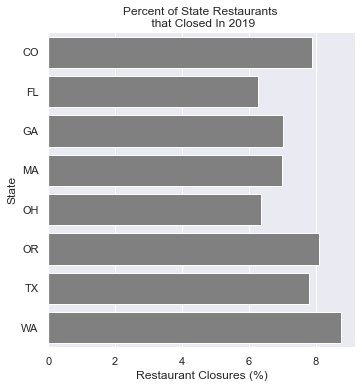

In [17]:
# Percent of restaurant closures per state in 2019

# Divide num of closed restaurants by total restaurants in each state
group_state = bus_unique.groupby('state').count()
closed_state = bus_unique[bus_unique['is_open'] == 0].groupby('state').count()
closed = (closed_state / group_state) * 100

# Merge dataset to make data workable, then visualize data
closed.reset_index(inplace=True)
pc_plt = sns.catplot(data= closed.dropna(), x="is_open", y="state", height= 5, color = "gray", kind="bar")
pc_plt.set(xlabel='Restaurant Closures (%)', ylabel='State', title='Percent of State Restaurants \n that Closed In 2019')

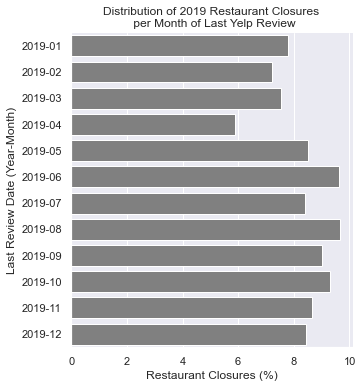

In [14]:
# Percent of 2019 closures per month of last review

group_date = len(bus_unique[bus_unique['is_open'] == 0])
closed_date = bus_unique[bus_unique['is_open'] == 0].groupby('month-year').count()
closed = (closed_date / group_date) * 100

closed.reset_index(inplace=True)
c = sns.catplot(data= closed, x="is_open", y="month-year", height= 5, color = "gray", kind="bar")
c.set(xlabel='Restaurant Closures (%)', ylabel='Last Review Date (Year-Month)', title='Distribution of 2019 Restaurant Closures \n per Month of Last Yelp Review')

In [15]:
# Percent of reviews per month
tot_revs = len(closed_revs) + len(open_revs)
group_num = open_revs.groupby('month-year').count() + closed_revs.groupby('month-year').count()
group_num = (group_num / tot_revs) * 100
group_num = group_num.dropna()
group_num.reset_index(inplace=True)

n = sns.catplot(data= group_num, x="date", y="month-year", height= 5, color = "gray", kind="bar")
n.set(xlabel='Reviews (%)', ylabel='Review Date (Year-Month)', title='Distribution of 2019 Reviews per Month')

In [16]:
# Percent diff between the closed last review distribution and total review distribution
group_num['dif'] = closed['date'] - group_num['date']
group_num['Increased Closures?'] = group_num['dif'] > 0

n = sns.catplot(data= group_num, x="dif", y="month-year", height= 5, hue ="Increased Closures?", kind="bar")
n.set(xlabel='Difference of Closed Restaurant Last Review \n and All Restaurant Review (%)', ylabel='Date (Year-Month)', title='Difference in Percent of Closed and All Restaurant \n Last Reviews per Month in 2019')